## Исследование алгоритма, построенного на ассоциативных правилах

В этом файле изучается зависимость охвата по элементам (то есть процент фильмов, попадающих в рекомендации хотя бы одному человеку) от разных параметров, частота попадания фильмов в рекомендации и время работы алгоритма.

### Часть 1. Охват

In [1]:
import pandas as pd
import os
import numpy as np
from collections import defaultdict
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '../data/'

In [3]:
transactions_main = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

In [4]:
transactions_main.head(6)

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50
3,6272,74296,S,4.430518e+07,2530,0,99
4,5543,340623,P,4.430518e+07,6282,0,50
5,236,332814,S,4.430518e+07,3109,0,50


In [5]:
def get_rec_list(trans_dict: dict, user, rules: list): # функция-часть main() из файла 'associative_rules.py'

    recs_list = []

    for rule in rules:
        for element_id in trans_dict[user]:
            if rule[0] == element_id:
                recs_list.append(rule)

    recs_list = sorted(recs_list, key = lambda l : l[2], reverse = True)
    
    # удаляем дубликаты, пересчитывая поддержку как среднее арифметическое
    # поддержок всех рекомендаций соответствующего элемента
    recs_dict = {}

    for rec in recs_list:
        if rec[1] not in recs_dict:
            recs_dict[rec[1]] = [rec[2], 1]
        else:
            (recs_dict[rec[1]])[0] += rec[2]
            (recs_dict[rec[1]])[1] += 1

    recs_list_final = []
        
    for key, item in recs_dict.items():
        recs_list_final.append((key, item[0]/item[1]))
    
    recs_list_final = sorted(recs_list_final, key = lambda t : t[1], reverse = True)

    return [t[0] for t in recs_list_final]

In [6]:
import sys 
sys.path.append('../code/')
from associative_rules import generate_transactions, calculate_itemsets_one
from associative_rules import calculate_itemsets_two, calculate_association_rules, get_rec_list 

In [7]:
def main(data):
    transactions_dict = generate_transactions(data)
    users = transactions_dict.keys()
    
    coverage_list = []
    movies_rec_sets = [set() for i in range(5)]
    
    n = len(data['element_uid'].unique())
    
    for t in np.linspace(0, 0.005, 5):
        k = int(t // 0.00125)
        one_itemsets = calculate_itemsets_one(transactions_dict, t)
        two_itemsets = calculate_itemsets_two(transactions_dict, one_itemsets)
        rules = calculate_association_rules(one_itemsets, two_itemsets, len(transactions_dict))
    
        # составляю рекомендации для каждого пользователя с определённным порогом поддержки
        # и добавляю 5 лучших во множество всех рекомендованных фильмов movies_rec_sets
        for user in users:
            l = get_rec_list(transactions_dict, user, rules)
            movies_rec_sets[k] |= set(l[:5])
        
        c = (len(movies_rec_sets[k]) / n)
        coverage_list.append(c)
        
    return coverage_list

In [8]:
transactions = transactions_main.iloc[:30000][['element_uid', 'user_uid']]

In [9]:
coverage_list = main(transactions)

In [10]:
coverage_list = [i*100 for i in coverage_list] # перевожу в проценты
coverage_list

[69.36722266348954,
 6.777866031241726,
 2.7270320360074134,
 2.7270320360074134,
 0.7413290971670639]

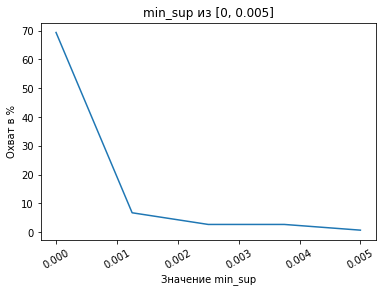

In [11]:
plt.plot(np.linspace(0, 0.005, 5), 
         coverage_list)
plt.xticks(rotation=30)
plt.xlabel('Значение min_sup') 
plt.ylabel('Охват в %')
plt.title('min_sup из [0, 0.005]')
plt.savefig('ar_coverage1.png', 
            transparent=True, 
            bbox_inches='tight')
plt.show()

**Наблюдение:** \
Охват заметно убывает при увеличении порога поддержки (min_sup). \
Вопрос выбора порога --- это вопрос баланса между качеством и количеством, так как, уменьшая порог, мы уменьшаем нашу уверенность в том, что наши рекомендации релевантны и понравятся пользователю. При этом, избавляясь от условия необходимости наличия определенной поддержки (иначе говоря, полагая порог равным нулю), мы получаем охват, равный почти 70%, то есть 70% от всех фильмов попадают в рекомендации. А при пороге поддержки, равном 0.0025, более 70% остаются неохваченными, то есть не могут обнаружены благодаря рекомендациям --- см.далее.

На графике выше видно, что резкое падение значения происходит на промежутке $[0,0.001]$ - рассмотрим подробнее: 

In [12]:
def main2(data):
    transactions_dict = generate_transactions(data)
    users = transactions_dict.keys()
    
    coverage_list = []
    movies_rec_sets = [set() for i in range(5)]
    
    n = len(data['element_uid'].unique())
    
    for t in np.linspace(0, 0.001, 5): # аналогично main(), но для значений min_sup из [0, 0.001]
        k = int(t // 0.0002)
        one_itemsets = calculate_itemsets_one(transactions_dict, t)
        two_itemsets = calculate_itemsets_two(transactions_dict, one_itemsets)
        rules = calculate_association_rules(one_itemsets, two_itemsets, len(transactions_dict))
    
        for user in users:
            l = get_rec_list(transactions_dict, user, rules)
            movies_rec_sets[k] |= set(l[:5])
        
        c = (len(movies_rec_sets[k]) / n)
        coverage_list.append(c)
        
    return coverage_list

In [13]:
transactions = transactions_main.iloc[:30000][['element_uid', 'user_uid']]

In [14]:
coverage_list_2 = main2(transactions)

In [15]:
coverage_list_2 = [i*100 for i in coverage_list_2] # перевожу в проценты
coverage_list_2

[69.36722266348954,
 30.394492983849613,
 17.500661900979615,
 12.417262377548319,
 9.10775747948107]

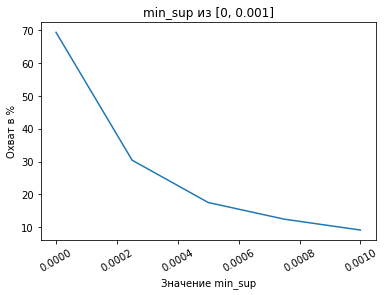

In [16]:
plt.plot(np.linspace(0, 0.001, 5), 
         coverage_list_2)
plt.xticks(rotation=30)
plt.xlabel('Значение min_sup') 
plt.ylabel('Охват в %')
plt.title('min_sup из [0, 0.001]')
plt.savefig('ar_coverage2.png', 
            transparent=True, 
            bbox_inches='tight')
plt.show()

Выбираю значение min_sup = 0.0001 как оптимальное - в этом случае хотя бы половина фильмов попадёт в рекомендации пользователям.

In [17]:
def main3(data):
    transactions_dict = generate_transactions(data)
    users = transactions_dict.keys()
    
    coverage_list = []
    movies_rec_sets = [set() for i in range(5)]
    
    n = len(data['element_uid'].unique())
    
    one_itemsets = calculate_itemsets_one(transactions_dict, 0.0001)
    two_itemsets = calculate_itemsets_two(transactions_dict, one_itemsets)
    rules = calculate_association_rules(one_itemsets, two_itemsets, len(transactions_dict))
    
    for user in users:
        l = get_rec_list(transactions_dict, user, rules)
        
        for i in range(5, 30, 5):
            if i < len(l):
                movies_rec_sets[i // 5 - 1] |= set(l[:i])
            else:
                movies_rec_sets[i // 5 - 1] |= set(l)
                
    for j in range(5):    
        c = (len(movies_rec_sets[j]) / n)
        coverage_list.append(c)
        
    return coverage_list

In [18]:
transactions = transactions_main.iloc[:30000][['element_uid', 'user_uid']]

In [19]:
coverage_list_3 = main3(transactions)

In [20]:
coverage_list_3 = [i*100 for i in coverage_list_3] # перевожу в проценты
coverage_list_3

[53.53455123113582,
 56.42043950225046,
 57.744241461477365,
 58.61795075456712,
 58.909187185597034]

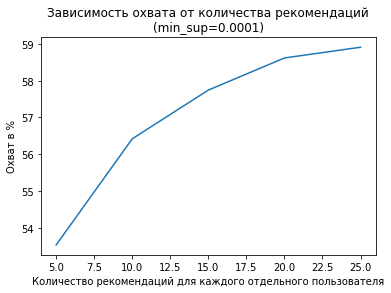

In [21]:
plt.plot(np.linspace(5, 25, 5), 
         coverage_list_3)
plt.xlabel('Количество рекомендаций для каждого отдельного пользователя') 
plt.ylabel('Охват в %')
plt.title('Зависимость охвата от количества рекомендаций\n'
          '(min_sup=0.0001)')
plt.savefig('ar_coverage3.png', 
            transparent=True,
            bbox_inches='tight')
plt.show()

**Наблюдение:** \
Значение охвата не сильно меняется при увеличении количества рекомендаций для каждого пользователя (рассматриваю сетку от 5 до 25 включительно с шагом 5). Однако, как логично предположить, чем больше рекомендаций для каждого конкретного пользователя мы выделяем, тем больше разнообразие рекомендуемых фильмов. Учитывая, что в рекомендательной системе алгоритм, построенный при помощи ассоциативных правил, является не единственным, 10-ти рекомендаций будет вполне достаточно.

Таким образом, при min_sup = 0.0001 и 10-ти рекомендациях получаем охват 56%.

### Часть 2. Частота попадания в рекомендации

Посмотрим, как часто фильмы попадают в рекомендации.
Для этого будем отбирать лучшие 10 рекомендаций для каждого пользователя.

In [22]:
from collections import Counter
import seaborn as sns

In [23]:
def main4(data):
    transactions_dict = generate_transactions(data)
    users = transactions_dict.keys()

    movies_rec_list = np.array([])
    
    n = len(data['element_uid'].unique())
    
    one_itemsets = calculate_itemsets_one(transactions_dict, 0.0001)
    two_itemsets = calculate_itemsets_two(transactions_dict, one_itemsets)
    rules = calculate_association_rules(one_itemsets, two_itemsets, len(transactions_dict))
    
    for user in users:
        l = get_rec_list(transactions_dict, user, rules)[:10]
        movies_rec_list = np.concatenate((movies_rec_list, np.array(l)))
        
    return movies_rec_list

In [24]:
transactions = transactions_main.iloc[:30000][['element_uid', 'user_uid']]

In [25]:
movies_rec_list = main4(transactions)

In [26]:
freq = list(dict(Counter(movies_rec_list)).values())

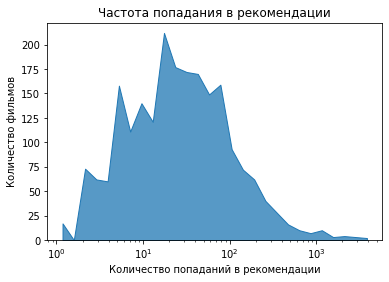

In [27]:
sns.histplot(x=freq, element="poly", log_scale=True)
plt.xlabel('Количество попаданий в рекомендации') 
plt.ylabel('Количество фильмов') 
plt.title('Частота попадания в рекомендации')
plt.savefig('ar_coverage4.png', 
            transparent=True, 
            bbox_inches='tight')
plt.show()

In [28]:
print('Среднее число попаданий в рекомендации:', round(np.mean(freq), 1))

Среднее число попаданий в рекомендации: 74.7


In [29]:
print('Число уникальных пользователей:', len(transactions['user_uid'].unique()))

Число уникальных пользователей: 18652


Приведённый выше график отражает зависимость количества фильмов от количества попаданий в рекомендации. Изучая его, можно заметить, что среди всех рекомендаций пользователям большинство фильмов (более 200) встречается около 20-ти раз - иначе говоря, попадает в рекомендации 20-ти пользователям. В среднем каждый фильм рекомендуется около 75-ти раз, но есть и экстремальные значения --- есть как фильмы, которые рекомендуются всего нескольким из 18-ти с лишним тысяч пользователей, так и те, что рекомендуются каждому 20-му. 

### Часть 3. Время работы

В силу того что рекомендации для каждого отдельного пользователя (при фиксированном их числе) на выходе определяются как срез списка уже отсортированных рекомендаций, время, затрачиваемое на генерацию 5-ти или 10-ти рекомендаций, почти не будет отличаться. 

In [30]:
import time

In [31]:
transactions = transactions_main.iloc[:30000]

In [37]:
def main5(user, transactions):
    start1_time = time.time()
    transactions_dict = generate_transactions(transactions)
    one_itemsets = calculate_itemsets_one(transactions_dict)
    two_itemsets = calculate_itemsets_two(transactions_dict, one_itemsets)
    rules = calculate_association_rules(one_itemsets, two_itemsets, len(transactions_dict))
    
    end1_time = time.time()
    start2_time = time.time_ns()
    recs_list = get_rec_list(transactions_dict, user, rules)[:10]
    
    end2_time = time.time_ns()
    
    return (recs_list, round(end1_time - start1_time, 2), round(end2_time - start2_time, 2))

In [38]:
user = 240316
recs_list, t1, t2 = main5(user, transactions)

In [39]:
print(f'Рекомендации для пользователя {user}:', recs_list)
print(f'Время на ассоциативные правила: {t1}s')
print(f'Время на рекомендации: {t2}ns')

Рекомендации для пользователя 240316: [9341, 9661, 2694, 8739, 4548, 4366, 6955, 9311, 603, 9817]
Время на ассоциативные правила: 1.0s
Время на рекомендации: 98691ns


10 рекомендаций этот алгоритм генерирует за примерно $10^{-4}$ секунды. А все предварительные вычисления выполняет за секунду (сразу для всех пользователей). Поэтому при подобном порядке размерности входных данных (30_000 строк) и небольшом потоке посетителей рекомендательный алгоритм может работать в онлайн-режиме, составляя рекомендации в тот момент, когда пользователь заходит на сайт, и выполняя общие вычисления по мере поступления новых данных с учётом текущей нагрузки на систему.